# 5.5 RNNLM 학습과 평가

5.5.1 RNNLM 구현

In [1]:
import numpy as np
from time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') # Xavier 초깃값
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f') # Xavier 초깃값
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f') # Xavier 초깃값
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from optimizer import SGD
from data import ptb

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소수
time_size = 5 # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1] # 입력
ts = corpus[1:] # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' %(corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size*time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 각 미니배치에서 샘플을 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i*jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니 배치 획득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
        
        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f' %(epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 359.87
| 에폭 2 | 퍼플렉서티 242.33
| 에폭 3 | 퍼플렉서티 219.40
| 에폭 4 | 퍼플렉서티 213.07
| 에폭 5 | 퍼플렉서티 205.04
| 에폭 6 | 퍼플렉서티 201.67
| 에폭 7 | 퍼플렉서티 198.20
| 에폭 8 | 퍼플렉서티 194.91
| 에폭 9 | 퍼플렉서티 190.80
| 에폭 10 | 퍼플렉서티 192.72
| 에폭 11 | 퍼플렉서티 189.03
| 에폭 12 | 퍼플렉서티 192.38
| 에폭 13 | 퍼플렉서티 189.68
| 에폭 14 | 퍼플렉서티 190.86
| 에폭 15 | 퍼플렉서티 190.72
| 에폭 16 | 퍼플렉서티 186.93
| 에폭 17 | 퍼플렉서티 184.14
| 에폭 18 | 퍼플렉서티 181.11
| 에폭 19 | 퍼플렉서티 182.94
| 에폭 20 | 퍼플렉서티 183.89
| 에폭 21 | 퍼플렉서티 181.94
| 에폭 22 | 퍼플렉서티 177.68
| 에폭 23 | 퍼플렉서티 174.66
| 에폭 24 | 퍼플렉서티 177.17
| 에폭 25 | 퍼플렉서티 174.61
| 에폭 26 | 퍼플렉서티 173.49
| 에폭 27 | 퍼플렉서티 169.32
| 에폭 28 | 퍼플렉서티 167.53
| 에폭 29 | 퍼플렉서티 163.97
| 에폭 30 | 퍼플렉서티 159.65
| 에폭 31 | 퍼플렉서티 160.02
| 에폭 32 | 퍼플렉서티 153.02
| 에폭 33 | 퍼플렉서티 153.59
| 에폭 34 | 퍼플렉서티 148.17
| 에폭 35 | 퍼플렉서티 146.96
| 에폭 36 | 퍼플렉서티 138.88
| 에폭 37 | 퍼플렉서티 135.45
| 에폭 38 | 퍼플렉서티 131.51
| 에폭 39 | 퍼플렉서티 127.28
| 에폭 40 | 퍼플렉서티 122.21
| 에폭 41 | 퍼플렉서티 120.78
| 에폭 42 | 퍼플렉서티 114.14
| 에폭 43 | 퍼플렉서티 108

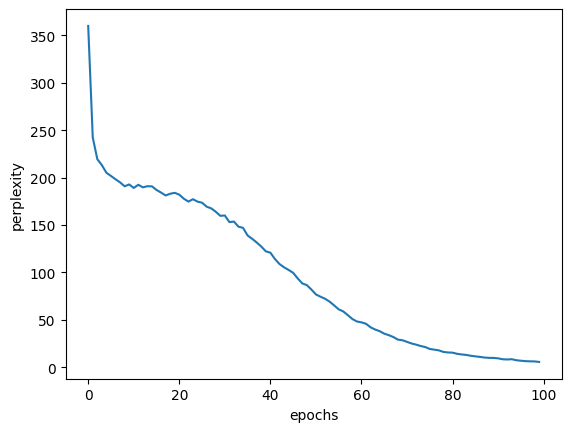

In [11]:
x = np.arange(len(ppl_list))

plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()